In [1]:
#IMPORT ALL THE REQUIRED LIBRARIES
import pandas as pd
import numpy as np # library to handle data in a vectorized manner
import requests # library to handle requests

from bs4 import BeautifulSoup
import os

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
import folium 
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Libraries imported.


In [35]:
source = requests.get('http://www.healthysf.org/bdi/outcomes/zipmap.htm').text
soup=BeautifulSoup(source,'lxml')
table = soup.find_all('table')
sf_data = pd.read_html(str(table))
sf_data = pd.DataFrame(sf_data[4])
sf_data.columns = sf_data.iloc[0]
sf_data = sf_data.iloc[1:-1,:-1]
sf_data[["Zip Code"]] = sf_data[["Zip Code"]].astype("int")

In [36]:
sf_data.rename(columns = {'Zip Code':'zip_code'}, inplace = True)
sf_data.head()

,zip_code,Neighborhood
1,94102,Hayes Valley/Tenderloin/North of Market
2,94103,South of Market
3,94107,Potrero Hill
4,94108,Chinatown
5,94109,Polk/Russian Hill (Nob Hill)


In [30]:
us_df=pd.read_csv('http://docs.gaslamp.media/wp-content/uploads/2013/08/zip_codes_states.csv')
us_df.head()

,zip_code,latitude,longitude,city,state,county
0,501,40.922326,-72.637078,Holtsville,NY,Suffolk
1,544,40.922326,-72.637078,Holtsville,NY,Suffolk
2,601,18.165273,-66.722583,Adjuntas,PR,Adjuntas
3,602,18.393103,-67.180953,Aguada,PR,Aguada
4,603,18.455913,-67.145780,Aguadilla,PR,Aguadilla


In [5]:
sf_df = pd.merge(sf_data,us_df, on = 'zip_code')
sf_df

,zip_code,Neighborhood,latitude,longitude,city,state,county
0,94102,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,San Francisco,CA,San Francisco
1,94103,South of Market,37.775678,-122.412131,San Francisco,CA,San Francisco
2,94107,Potrero Hill,37.769029,-122.393681,San Francisco,CA,San Francisco
3,94108,Chinatown,37.791028,-122.408782,San Francisco,CA,San Francisco
4,94109,Polk/Russian Hill (Nob Hill),37.795219,-122.420782,San Francisco,CA,San Francisco
5,94110,Inner Mission/Bernal Heights,37.748932,-122.416281,San Francisco,CA,San Francisco
6,94112,Ingelside-Excelsior/Crocker-Amazon,37.721981,-122.439382,San Francisco,CA,San Francisco
7,94114,Castro/Noe Valley,37.758279,-122.439332,San Francisco,CA,San Francisco
8,94115,Western Addition/Japantown,37.786028,-122.437032,San Francisco,CA,San Francisco
9,94116,Parkside/Forest Hill,37.743857,-122.483232,San Francisco,CA,San Francisco


In [6]:
CLIENT_ID = 'U3R4VWEOB5VLT3KEKQAZZWKYBNP5JUCWDGEFVUBN1H2OSUB0' # your Foursquare ID
CLIENT_SECRET = 'Q3GRYC04FD0IJFCC3GWC5D1DZVJNIMPOCA0R5NDU042DUEA0' # your Foursquare Secret
VERSION = '20210509'

In [7]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
sf_venues = getNearbyVenues(names=sf_df['Neighborhood'],
                                   latitudes=sf_df['latitude'],
                                   longitudes=sf_df['longitude']
                                  )

Hayes Valley/Tenderloin/North of Market
South of Market
Potrero Hill
Chinatown
Polk/Russian Hill (Nob Hill)
Inner Mission/Bernal Heights
Ingelside-Excelsior/Crocker-Amazon
Castro/Noe Valley
Western Addition/Japantown
Parkside/Forest Hill
Haight-Ashbury
Inner Richmond
Outer Richmond
Sunset
Marina
Bayview-Hunters Point
St. Francis Wood/Miraloma/West Portal
Twin Peaks-Glen Park
Lake Merced
North Beach/Chinatown
Visitacion Valley/Sunnydale


In [9]:
sf_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Asian Art Museum,37.780178,-122.416505,Art Museum
1,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Orpheum Theatre,37.779315,-122.414790,Theater
2,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Philz Coffee,37.781266,-122.416901,Coffee Shop
3,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Fermentation Lab,37.778368,-122.415313,Beer Bar
4,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Ananda Fuara,37.777693,-122.416353,Vegetarian / Vegan Restaurant


In [10]:
coffee_shops = sf_venues[sf_venues['Venue Category'] == 'Coffee Shop']
cafés = sf_venues[sf_venues['Venue Category'] == 'Café']
bubble_tea_shops = sf_venues[sf_venues['Venue Category'] == 'Bubble Tea Shop']
bakeries = sf_venues[sf_venues['Venue Category'] == 'Bakery']

In [11]:
coffee_data = sf_venues[sf_venues['Venue Category'].isin(['Coffee Shop','Café','Bubble Tea Shop','Bakery'])]
neighborhoods = sf_venues['Neighborhood'].unique()
coffee_to_plot = np.array(coffee_data['Neighborhood'].value_counts())

In [12]:
coffee_data

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Philz Coffee,37.781266,-122.416901,Coffee Shop
10,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Blue Bottle Coffee,37.776286,-122.416867,Coffee Shop
13,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Arsicault Bakery,37.780789,-122.413433,Bakery
19,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Andersen Bread,37.776906,-122.417400,Bakery
45,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,All Star Cafe,37.776325,-122.414764,Café
...,...,...,...,...,...,...,...
1047,North Beach/Chinatown,37.801928,-122.410182,Cavalli Cafe,37.799315,-122.408861,Coffee Shop
1058,North Beach/Chinatown,37.801928,-122.410182,Cafe Francisco,37.804861,-122.411890,Coffee Shop
1060,North Beach/Chinatown,37.801928,-122.410182,DeLise,37.805772,-122.412708,Coffee Shop
1061,North Beach/Chinatown,37.801928,-122.410182,901 Columbus Caffe,37.802829,-122.414023,Café


([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

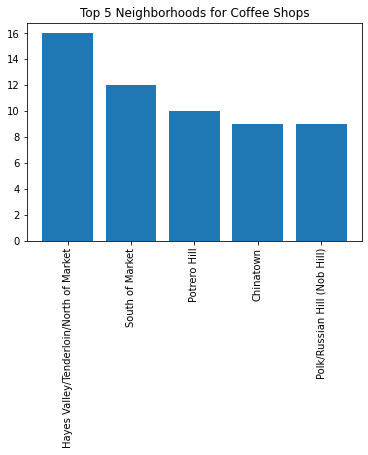

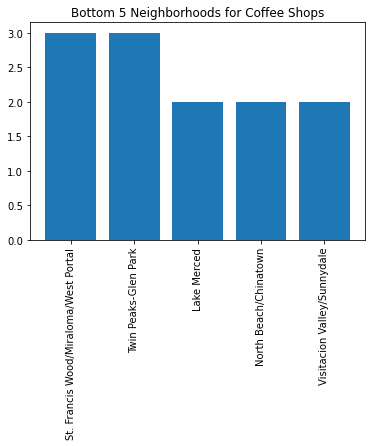

In [13]:
fig1 = plt.figure()
plt.title("Top 5 Neighborhoods for Coffee Shops")
plt.bar(neighborhoods[:5],coffee_to_plot[:5])
plt.xticks(rotation = 90)

fig2 = plt.figure()
plt.title("Bottom 5 Neighborhoods for Coffee Shops")
plt.bar(neighborhoods[-5:],coffee_to_plot[-5:])
plt.xticks(rotation = 90) 

In [14]:
# one hot encoding
sf_onehot = pd.get_dummies(coffee_data[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sf_onehot['Neighborhood'] = coffee_data['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sf_onehot.columns[-1]] + list(sf_onehot.columns[:-1])
sf_onehot = sf_onehot[fixed_columns]

sf_grouped = sf_onehot.groupby('Neighborhood').mean().reset_index()

In [15]:
# set number of clusters
kclusters = 8

sf_grouped_clustering = sf_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sf_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 5, 7, 0, 6, 7, 1, 6, 7], dtype=int32)

In [16]:
# add clustering labels
sf_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

sf_merged = coffee_data

In [17]:
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
sf_merged = sf_merged.join(sf_grouped.set_index('Neighborhood'), on='Neighborhood')

sf_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,Bakery,Bubble Tea Shop,Café,Coffee Shop
2,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Philz Coffee,37.781266,-122.416901,Coffee Shop,7,0.222222,0.111111,0.333333,0.333333
10,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Blue Bottle Coffee,37.776286,-122.416867,Coffee Shop,7,0.222222,0.111111,0.333333,0.333333
13,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Arsicault Bakery,37.780789,-122.413433,Bakery,7,0.222222,0.111111,0.333333,0.333333
19,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,Andersen Bread,37.776906,-122.417400,Bakery,7,0.222222,0.111111,0.333333,0.333333
45,Hayes Valley/Tenderloin/North of Market,37.779278,-122.416582,All Star Cafe,37.776325,-122.414764,Café,7,0.222222,0.111111,0.333333,0.333333


In [18]:
address = 'San Francisco, CA'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of San Francisco are 37.7790262, -122.419906.


In [19]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, venue, poi, cluster in zip(sf_merged['Venue Latitude'], sf_merged['Venue Longitude'], sf_merged['Venue Category'], sf_merged['Neighborhood'], sf_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' ' + str(venue), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters